# 1. Quá trình dự báo trên mô hình LR

## Thêm thư viện

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.tsa.stattools import adfuller


from sklearn.metrics import mean_squared_error
from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

## Nạp dữ liệu từ file csv

In [4]:
df = pd.read_csv('btc.csv', parse_dates=True,
                 index_col=0).drop(columns=['Open', 'High', 'Low', 'Volume', 'Currency'])
df

,Close
Date,
2020-06-01,1.01893
2020-06-02,0.95276
2020-06-03,0.96672
2020-06-04,0.97944
2020-06-05,0.96312
...,...
2022-05-28,2.90271
2022-05-29,2.94652
2022-05-30,3.17233


In [5]:
df['Timestamp'] = pd.to_datetime(df.index).astype(np.int64) / 10**9
df_index = df.index
df_close = df['Close'].values.reshape(-1, 1)
df.head()

df

,Close,Timestamp
Date,,
2020-06-01,1.01893,1.590970e+09
2020-06-02,0.95276,1.591056e+09
2020-06-03,0.96672,1.591142e+09
2020-06-04,0.97944,1.591229e+09
2020-06-05,0.96312,1.591315e+09
...,...,...
2022-05-28,2.90271,1.653696e+09
2022-05-29,2.94652,1.653782e+09
2022-05-30,3.17233,1.653869e+09


## Chuẩn hóa dữ liệu

In [6]:
LR_sc = StandardScaler()

df_scaled = df.copy()
df_scaled['Close'] = LR_sc.fit_transform(df_close)
df_scaled

,Close,Timestamp
Date,,
2020-06-01,-1.526877,1.590970e+09
2020-06-02,-1.566503,1.591056e+09
2020-06-03,-1.558143,1.591142e+09
2020-06-04,-1.550526,1.591229e+09
2020-06-05,-1.560299,1.591315e+09
...,...,...
2022-05-28,-0.398775,1.653696e+09
2022-05-29,-0.372539,1.653782e+09
2022-05-30,-0.237313,1.653869e+09


## Vẽ đồ thị

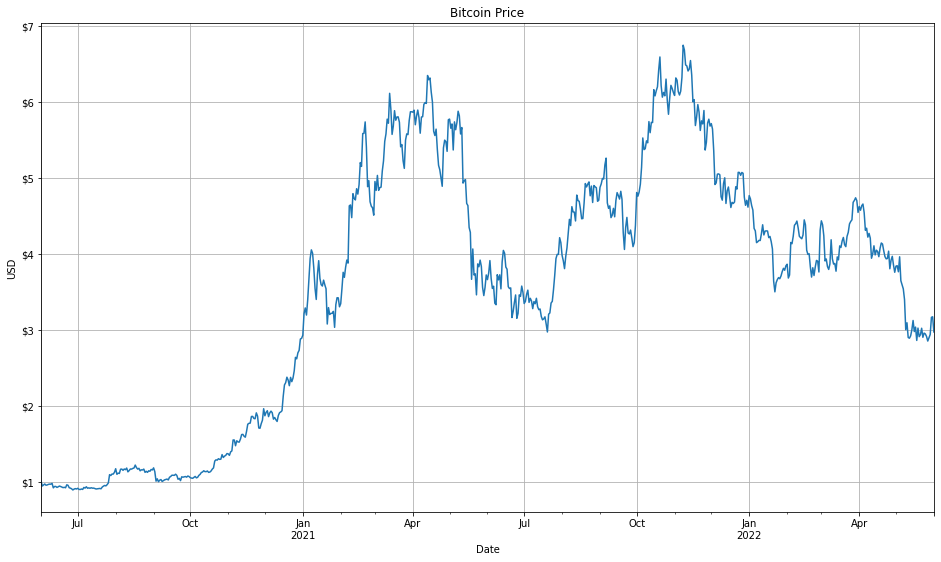

In [7]:
# Thư viện vẽ đồ thị
formatter = ticker.StrMethodFormatter('${x:,.0f}')

title = 'Bitcoin Price'
ylabel = 'USD'
xlabel = 'Date'

ax = df['Close'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

In [8]:
df

,Close,Timestamp
Date,,
2020-06-01,1.01893,1.590970e+09
2020-06-02,0.95276,1.591056e+09
2020-06-03,0.96672,1.591142e+09
2020-06-04,0.97944,1.591229e+09
2020-06-05,0.96312,1.591315e+09
...,...,...
2022-05-28,2.90271,1.653696e+09
2022-05-29,2.94652,1.653782e+09
2022-05-30,3.17233,1.653869e+09


## Chuẩn hóa dữ liệu

In [9]:
X_sc = StandardScaler()
y_sc = StandardScaler()

X = df.iloc[:, 1].values.reshape(-1, 1)
y = df.iloc[:, 0].values.reshape(-1, 1)


X_scaled = X_sc.fit_transform(X)
y_scaled = y_sc.fit_transform(y)


df_scaled = pd.DataFrame(index=df_index)
df_scaled['Timestamp'] = X_scaled
df_scaled['Close'] = y_scaled
df_scaled.head()


,Timestamp,Close
Date,,
2020-06-01,-1.729683,-1.526877
2020-06-02,-1.724944,-1.566503
2020-06-03,-1.720205,-1.558143
2020-06-04,-1.715466,-1.550526
2020-06-05,-1.710728,-1.560299


## Chia tập dữ liệu

In [10]:
interrupt = int(len(df_scaled) * .9)
interrupt


657

In [11]:
train_data, test_data = df_scaled[:interrupt], df_scaled[interrupt:]
index_test = df_scaled.index[interrupt:]
print(train_data.shape)
print(test_data.shape)


(657, 2)
(74, 2)


In [12]:
train_data.tail()

,Timestamp,Close
Date,,
2022-03-15,1.360052,0.215562
2022-03-16,1.364791,0.325331
2022-03-17,1.369530,0.313121
2022-03-18,1.374269,0.364202
2022-03-19,1.379008,0.392061


In [13]:
test_data.head()

,Timestamp,Close
Date,,
2022-03-20,1.383746,0.334751
2022-03-21,1.388485,0.319540
2022-03-22,1.393224,0.400445
2022-03-23,1.397963,0.432723
2022-03-24,1.402702,0.498656


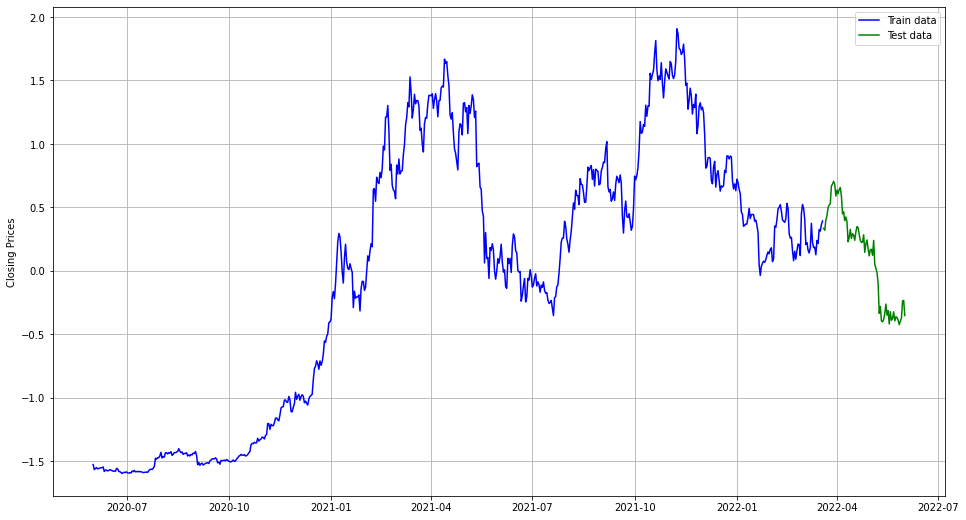

In [14]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Closing Prices')
plt.plot(train_data['Close'], 'blue', label='Train data')
plt.plot(test_data['Close'], 'green', label='Test data')
plt.legend()




*   Gọi biến X <- Timestamp
*   Gọi biến y <- Close




In [15]:
X_train = train_data['Timestamp'].values.reshape(-1, 1)
y_train = train_data['Close'].values.reshape(-1, 1)

X_test = test_data['Timestamp'].values.reshape(-1, 1)
y_test = test_data['Close'].values.reshape(-1, 1)


In [16]:
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression()
LR_model.fit(X_train,y_train)
pred = LR_model.predict(X_test)

In [17]:
inv_pred = y_sc.inverse_transform(pred.reshape(-1, 1))
inv_test = y_sc.inverse_transform(y_test.reshape(-1, 1))

## Vẽ đồ thị cho tập test và kết quả dự đoán

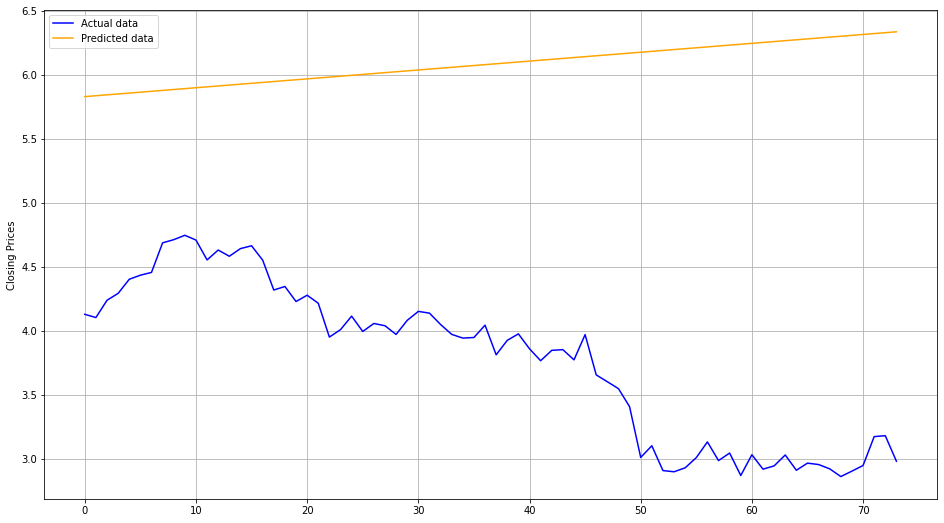

In [18]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Closing Prices')
plt.plot(column_or_1d(inv_test), 'blue', label='Actual data')
plt.plot(column_or_1d(inv_pred), 'orange', label='Predicted data')
plt.legend()


In [19]:
from sklearn.metrics import r2_score
mae = mean_absolute_error(inv_test, inv_pred)
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_test, inv_pred)
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 2.31
MAPE: 66.53%
MSE: 5.91
RMSE: 2.43
R2: -14.87


## Tạo một DataFrame là 'df_pred' để lưu kết quả dự đoán trên mô hình LR

In [20]:
df_pred = pd.DataFrame(columns=['Actual', 'Pred', 'Error'], index=index_test)
df_pred['Actual'] = column_or_1d(inv_test)
df_pred['Pred'] = column_or_1d(inv_pred)
df_pred['Error'] = df_pred['Actual'] - df_pred['Pred']
df_pred

,Actual,Pred,Error
Date,,,
2022-03-20,4.12760,5.828089,-1.700489
2022-03-21,4.10220,5.835025,-1.732825
2022-03-22,4.23730,5.841962,-1.604662
2022-03-23,4.29120,5.848898,-1.557698
2022-03-24,4.40130,5.855834,-1.454534
...,...,...,...
2022-05-28,2.90271,6.306696,-3.403986
2022-05-29,2.94652,6.313632,-3.367112
2022-05-30,3.17233,6.320569,-3.148239


# 2. Quá trình dự đoán trên mô hình LSTM

## Tạo thêm một DataFrame để tiến hành dự đoán sai số trên mô hình LSTM

In [21]:
df_lstm = df_pred.copy()
df_lstm

,Actual,Pred,Error
Date,,,
2022-03-20,4.12760,5.828089,-1.700489
2022-03-21,4.10220,5.835025,-1.732825
2022-03-22,4.23730,5.841962,-1.604662
2022-03-23,4.29120,5.848898,-1.557698
2022-03-24,4.40130,5.855834,-1.454534
...,...,...,...
2022-05-28,2.90271,6.306696,-3.403986
2022-05-29,2.94652,6.313632,-3.367112
2022-05-30,3.17233,6.320569,-3.148239


## Vẽ đồ thị thể hiện sai số

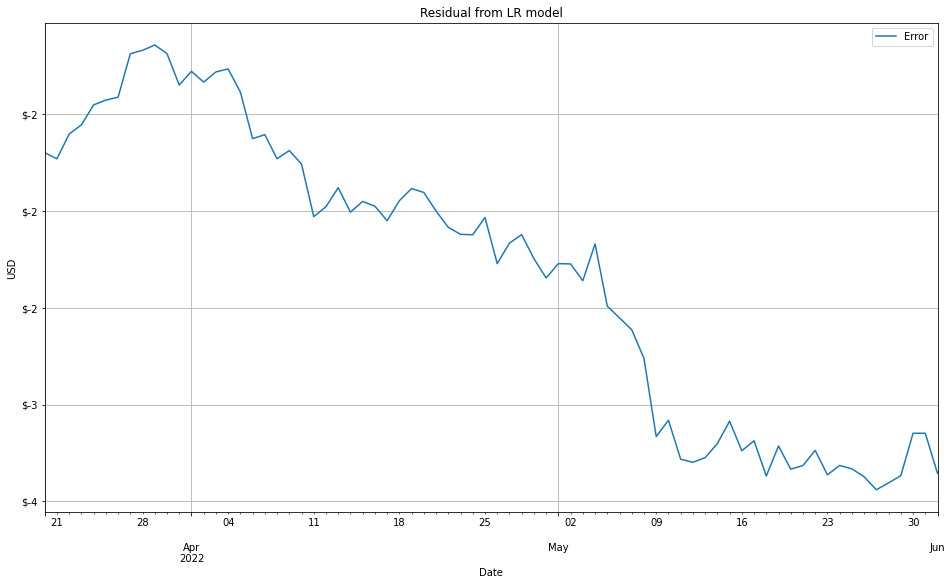

In [22]:
formatter = ticker.StrMethodFormatter('${x:,.0f}')

error = df_lstm[['Error']]
title = 'Residual from LR model'
ylabel = 'USD'
xlabel = 'Date'

ax = error.plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

In [23]:
error = np.array(error)
error

array([[-1.70048891],
       [-1.73282525],
       [-1.60466158],
       [-1.55769791],
       [-1.45453424],
       [-1.42967058],
       [-1.41490691],
       [-1.19074324],
       [-1.17307957],
       [-1.14561591],
       [-1.18995224],
       [-1.35188857],
       [-1.2816249 ],
       [-1.33716123],
       [-1.28449757],
       [-1.2692339 ],
       [-1.38847023],
       [-1.62870656],
       [-1.6081429 ],
       [-1.73237923],
       [-1.69011556],
       [-1.75995189],
       [-2.03098823],
       [-1.97982456],
       [-1.88126089],
       [-2.00789722],
       [-1.95243355],
       [-1.97716989],
       [-2.05200622],
       [-1.94894255],
       [-1.88587888],
       [-1.90631522],
       [-2.00185155],
       [-2.08608788],
       [-2.12212421],
       [-2.12446054],
       [-2.03509688],
       [-2.27343321],
       [-2.16736954],
       [-2.12380587],
       [-2.24744221],
       [-2.34747854],
       [-2.27331487],
       [-2.2749512 ],
       [-2.36148754],
       [-2

In [24]:
look_back = 3
x_total, y_total = [], []
for i in range(look_back, len(error)):
	x_total.append(error[i-look_back:i])
	y_total.append(error[i])
x_train = np.array(x_total[:len(error)])
y_train = np.array(y_total[:len(error)])

print("x_train",x_train.shape)
print("y_train",y_train.shape)


x_train (71, 3, 1)
y_train (71, 1)


In [25]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(x_train, y_train, epochs=300, verbose=1)
model.save("bitcoin.h5")

Epoch 1/300
3/3 [==============================] - 3s 8ms/step - loss: 5.9999
Epoch 2/300
3/3 [==============================] - 0s 8ms/step - loss: 5.8741
Epoch 3/300
3/3 [==============================] - 0s 7ms/step - loss: 5.7594
Epoch 4/300
3/3 [==============================] - 0s 8ms/step - loss: 5.6377
Epoch 5/300
3/3 [==============================] - 0s 8ms/step - loss: 5.5131
Epoch 6/300
3/3 [==============================] - 0s 11ms/step - loss: 5.3837
Epoch 7/300
3/3 [==============================] - 0s 8ms/step - loss: 5.2360
Epoch 8/300
3/3 [==============================] - 0s 9ms/step - loss: 5.0817
Epoch 9/300
3/3 [==============================] - 0s 8ms/step - loss: 4.8907
Epoch 10/300
3/3 [==============================] - 0s 8ms/step - loss: 4.6687
Epoch 11/300
3/3 [==============================] - 0s 8ms/step - loss: 4.3960
Epoch 12/300
3/3 [==============================] - 0s 8ms/step - loss: 4.0790
Epoch 13/300
3/3 [==============================] - 0s 8ms/s

In [26]:
model = load_model("bitcoin.h5")
error_pred = model.predict(x_train)
error_pred

array([[-1.7527189],
       [-1.7231185],
       [-1.6426433],
       [-1.5919552],
       [-1.5422581],
       [-1.49804  ],
       [-1.4313655],
       [-1.3394563],
       [-1.331801 ],
       [-1.3536706],
       [-1.4021225],
       [-1.4527897],
       [-1.4333975],
       [-1.4388691],
       [-1.4307104],
       [-1.4879624],
       [-1.5963014],
       [-1.7059078],
       [-1.7263048],
       [-1.7764407],
       [-1.8179793],
       [-1.9199275],
       [-2.009977 ],
       [-1.9765673],
       [-1.9624671],
       [-2.0059547],
       [-2.000003 ],
       [-2.0180671],
       [-2.010733 ],
       [-1.948939 ],
       [-1.9415843],
       [-1.992016 ],
       [-2.0661964],
       [-2.1162086],
       [-2.1196053],
       [-2.1299193],
       [-2.1463957],
       [-2.2174978],
       [-2.1735554],
       [-2.2078862],
       [-2.2865767],
       [-2.3108428],
       [-2.28972  ],
       [-2.287879 ],
       [-2.3194394],
       [-2.3417215],
       [-2.5299225],
       [-2.60

In [27]:
df_lstm

,Actual,Pred,Error
Date,,,
2022-03-20,4.12760,5.828089,-1.700489
2022-03-21,4.10220,5.835025,-1.732825
2022-03-22,4.23730,5.841962,-1.604662
2022-03-23,4.29120,5.848898,-1.557698
2022-03-24,4.40130,5.855834,-1.454534
...,...,...,...
2022-05-28,2.90271,6.306696,-3.403986
2022-05-29,2.94652,6.313632,-3.367112
2022-05-30,3.17233,6.320569,-3.148239


In [28]:
df_lstm = df_lstm.copy().head(len(error_pred))
df_lstm['Error Prediction'] = error_pred
df_lstm

,Actual,Pred,Error,Error Prediction
Date,,,,
2022-03-20,4.12760,5.828089,-1.700489,-1.752719
2022-03-21,4.10220,5.835025,-1.732825,-1.723119
2022-03-22,4.23730,5.841962,-1.604662,-1.642643
2022-03-23,4.29120,5.848898,-1.557698,-1.591955
2022-03-24,4.40130,5.855834,-1.454534,-1.542258
...,...,...,...,...
2022-05-25,2.95406,6.285887,-3.331827,-3.416748
2022-05-26,2.92035,6.292823,-3.372473,-3.459836
2022-05-27,2.86012,6.299760,-3.439640,-3.479463


In [29]:
df_lstm['LR_LSTM'] = df_lstm['Pred'] + df_lstm['Error Prediction']
df_lstm

,Actual,Pred,Error,Error Prediction,LR_LSTM
Date,,,,,
2022-03-20,4.12760,5.828089,-1.700489,-1.752719,4.075370
2022-03-21,4.10220,5.835025,-1.732825,-1.723119,4.111907
2022-03-22,4.23730,5.841962,-1.604662,-1.642643,4.199318
2022-03-23,4.29120,5.848898,-1.557698,-1.591955,4.256943
2022-03-24,4.40130,5.855834,-1.454534,-1.542258,4.313576
...,...,...,...,...,...
2022-05-25,2.95406,6.285887,-3.331827,-3.416748,2.869139
2022-05-26,2.92035,6.292823,-3.372473,-3.459836,2.832987
2022-05-27,2.86012,6.299760,-3.439640,-3.479463,2.820297


## Vẽ đồ thị

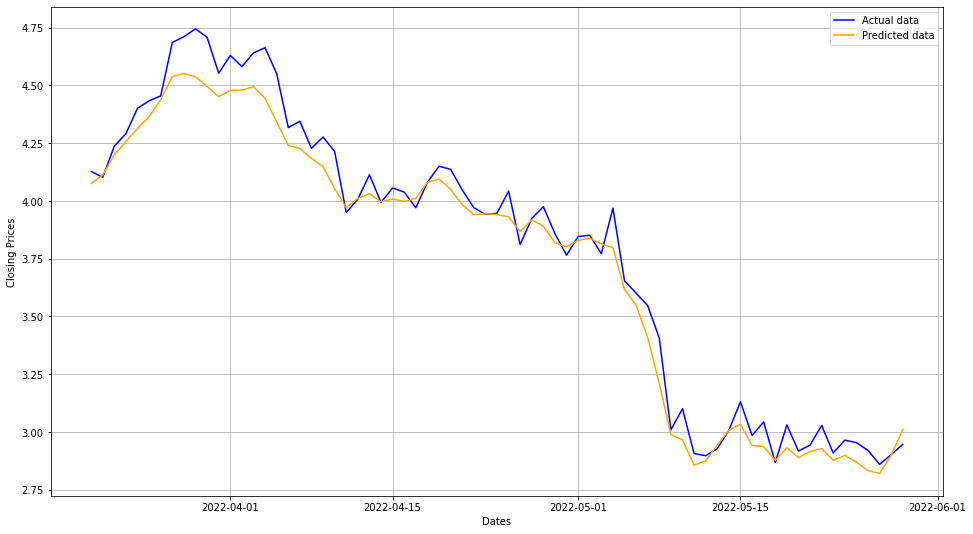

In [30]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_lstm['Actual'], 'blue', label='Actual data')
plt.plot(df_lstm['LR_LSTM'], 'orange', label='Predicted data')
plt.legend()

## Đánh giá mô hình

In [31]:
from sklearn.metrics import r2_score
mae = mean_absolute_error(df_lstm.Actual, df_lstm.LR_LSTM)
mape = mean_absolute_percentage_error(df_lstm.Actual, df_lstm.LR_LSTM)
mse = mean_squared_error(df_lstm.Actual, df_lstm.LR_LSTM)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 0.07
MAPE: 1.85%
MSE: 0.01
RMSE: 0.09
R2: -14.87


## Lấy 3 ngày cuối ra để dự báo

In [32]:
forecast = df_lstm['Error'].tail(3)
forecast

Date
2022-05-27   -3.439640
2022-05-28   -3.403986
2022-05-29   -3.367112
Name: Error, dtype: float64

## Đưa về ma trận

In [33]:
dataX = []
for i in range(len(forecast)):
    a=forecast[i]
    dataX.append(a)
dataX = np.array(dataX).reshape(1,-1,1)
dataX

array([[[-3.43963951],
        [-3.40398584],
        [-3.36711218]]])

In [34]:
y_forecast= model.predict(dataX).reshape(1,)
y_forecast

array([-3.479463], dtype=float32)

## So sánh kết quả dự đoán với giá trị thực

In [35]:
y_LR = df_pred.copy()
y_LR = y_LR.tail(4).head(1)
y_LR

,Actual,Pred,Error
Date,,,
2022-05-29,2.94652,6.313632,-3.367112


In [36]:
y_LR['Final_LSTM'] = y_LR.Pred + y_forecast
y_LR

,Actual,Pred,Error,Final_LSTM
Date,,,,
2022-05-29,2.94652,6.313632,-3.367112,2.834169


## Ghi ra file csv

In [37]:
df.to_csv("processed_data.csv")
df_scaled.to_csv("scaled_data.csv")
df_pred.to_csv("LR-PRED.csv")
df_lstm.to_csv("LSTM_PRED.csv")
y_LR.to_csv("Forecast.csv")